In [1]:
import numpy as np
import matplotlib.pyplot as plt
import GCRCatalogs
import pyccl as ccl

gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

cosmo = ccl.Cosmology(Omega_c=gc.cosmology.Om0-gc.cosmology.Ob0,
                      Omega_b=gc.cosmology.Ob0, h=gc.cosmology.h,
                      sigma8=gc.cosmology.sigma8,
                      n_s=gc.cosmology.n_s) 

def delta_c(c):
    return 200.0*c**3/( 3.0*(np.log(1+c)-c/(1.0+c)) )

def rho_cr(z):
    return ccl.background.rho_x(cosmo,1/(1+z),'critical', is_comoving=False)

def R_S(M_200,c):
    r200 = pow(3*M_200/(800*np.pi*rho_cr(z_L)),1.0/3.0)
    return r200/c

def Sigma_nfw(x):
    y = np.zeros(x.shape)
    mask1 = x<1
    x1 = x[mask1]
    mask2 = x==1
    mask3 = x>1
    x3 = x[mask3]
    y[mask1] = (  1-2*np.arctanh(np.sqrt((1.0-x1)/(1.0+x1)))/np.sqrt(1.0-pow(x1,2))  )/(pow(x1,2)-1.0)
    y[mask2] = 1.0/3.0
    y[mask3] = (  1-2*np.arctan(np.sqrt((x3-1.0)/(1.0+x3)))/np.sqrt(pow(x3,2)-1.0)  )/(pow(x3,2)-1.0)
    return 2*y

def gamma_nfw(x):
    y = np.zeros_like(x)
    mask1 = x<1
    x1 = x[mask1]
    mask2 = x==1
    mask3 = x>1
    x3 = x[mask3]
    y[mask1] = 8*np.arctanh(np.sqrt((1.0-x1)/(1.0+x1)))/(x1**2*np.sqrt(1.0-x1**2))  +  4*np.log(x1/2.0)/x1**2  -  2.0/(x1**2-1.0)  +   4*np.arctanh(np.sqrt((1.0-x1)/(1.0+x1)))/((x1**2-1.0)*np.sqrt(1.0-x1**2))######
    y[mask2] = 10.0/3.0 +4*np.log(1.0/2.0)
    y[mask3] = 8*np.arctan(np.sqrt((x3-1.0)/(1.0+x3)))/(x3**2*np.sqrt(x3**2-1.0))  +  4*np.log(x3/2.0)/x3**2  -  2.0/(x3**2-1.0)  +   4*np.arctan(np.sqrt((x3-1.0)/(1.0+x3)))/pow(x3**2-1.0,1.5)######
    return y

G = 4.79*1e-20
z_L = 0.35
D_L = ccl.comoving_radial_distance(cosmo, 1/(1+z_L))/(1+z_L)
z_S = 1.0
D_S = ccl.comoving_radial_distance(cosmo, 1/(1+z_S))/(1+z_S)
D_SL = (ccl.comoving_radial_distance(cosmo, 1/(1+z_S)) - ccl.comoving_radial_distance(cosmo, 1/(1+z_L)))/(1+z_S)
Sigma_cr = D_S / (4 * np.pi * G * D_SL * D_L)

In [2]:
import numpy.fft as fft
import astropy.io.fits as pyfits
from astropy.convolution import convolve_fft

class deflector(object):
    def __init__(self,kappa,pad=False):
        self.kappa=kappa
        self.nx=kappa.shape[0]
        self.ny=kappa.shape[1]
        self.pad=pad
        if (pad):
            self.kpad()
        self.kx,self.ky=self.kernel()

    def kernel(self):
        x=np.linspace(-self.kappa.shape[0]/2.,self.kappa.shape[0]/2.,self.kappa.shape[0])
        y=np.linspace(-self.kappa.shape[1]/2.,self.kappa.shape[1]/2.,self.kappa.shape[1])
        kx,ky=np.meshgrid(x,y)
        norm=(kx**2+ky**2+1e-12)
        kx=kx/norm
        ky=ky/norm
        return(kx,ky)

    def angles(self):
        kappa_ft = fft.rfftn(self.kappa,axes=(0,1))
        kernelx_ft = fft.rfftn(self.kx,axes=(0,1),
                                     s=self.kappa.shape)
        kernely_ft = fft.rfftn(self.ky,axes=(0,1),
                                     s=self.kappa.shape)

        alphax = 1.0/np.pi*\
                fft.fftshift(fft.irfftn(kappa_ft*kernelx_ft))
        alphay = 1.0/np.pi*\
                fft.fftshift(fft.irfftn(kappa_ft*kernely_ft))
        return(alphax,alphay)
    
    def angles2(self):
        kx,ky=self.kernel()
        alphax=convolve_fft(self.kappa,kx,normalize_kernel=False,nan_treatment='fill',fft_pad=False,boundary='wrap')
        alphay=convolve_fft(self.kappa,ky,normalize_kernel=False,nan_treatment='fill',fft_pad=False,boundary='wrap')
        alphax*=1.0/np.pi
        alphay*=1.0/np.pi
        return(alphax,alphay)
    
    def kmap(self):
        return(self.kappa)
    
    def kpad(self):
        def padwithzeros(vector, pad_width, iaxis, kwargs):
            vector[:pad_width[0]] = 0
            vector[-pad_width[1]:] = 0
            return vector
        self.kappa=np.lib.pad(self.kappa, self.kappa.shape[0], 
                              padwithzeros)
    

    def mapCrop(self,mappa):

        xmin=np.int(self.kappa.shape[0]/2-self.nx/2)
        ymin=np.int(self.kappa.shape[1]/2-self.ny/2)
        xmax=np.int(xmin+self.nx)
        ymax=np.int(ymin+self.ny)
        mappa=mappa[xmin:xmax,ymin:ymax]
        return(mappa)

    def potential(self):
        k = np.array(np.meshgrid(fft.fftfreq(self.kappa.shape[0])\
                                 ,fft.fftfreq(self.kappa.shape[1]))).astype('float64')
        pix=1 
        kk = k[0]**2 + k[1]**2
        kk[0,0] = 1.0
        kappa_ft = fft.fftn(self.kappa)
        kappa_ft *= - pix**2 / (kk * (2.0*np.pi**2))
        kappa_ft[0,0] = 0.0
        potential=fft.ifftn(kappa_ft)
        return potential.real
    
def convergence(a1,a2):
    a12,a11=np.gradient(a1)
    a22,a21=np.gradient(a2)
    kappa=0.5*(a11+a22)
    return(kappa)

In [3]:
def rdiff(x0,y0,x,y):
    return np.sqrt((x-x0)**2+(y-y0)**2+1e-8)

def gen_kap(M0,x0,y0):
    rs0 = R_S(M0,c)
    y_unit = rs0*delta_c(c)*rho_cr(z_L)
    r0 = rdiff(x0,y0,X,Y)
    xx = r0/rs0
    return Sigma_nfw(xx)*y_unit/Sigma_cr


def gen_point_kap(M0,x0,y0):
    r0 = rdiff(x0,y0,X,Y)
    Sigma_point = M0/r0**2
    return Sigma_point/Sigma_cr

def gen_gam(M0,x0,y0):
    rs0 = R_S(M0,c)
    y_unit = rs0*delta_c(c)*rho_cr(z_L)
    r0 = rdiff(x0,y0,X,Y)
    xx = r0/rs0
    return gamma_nfw(xx)*y_unit/Sigma_cr

def gen_point_gam(M0,x0,y0):
    r0 = rdiff(x0,y0,X,Y)
    Delta_Sigma = M0/r0**2
    return Delta_Sigma/Sigma_cr

#point_gam = gen_point_gam(1e15,0.5,0)

In [4]:
def gamma_t(g1,g2, X, Y):
    X=X.flatten()
    Y=Y.flatten()
    g1 = g1.flatten()
    g2 = g2.flatten()
    r2center = X**2 + Y**2
    modr = np.sqrt(r2center+1e-8)
    cosphi = X/modr
    sinphi = Y/modr
    c2 = cosphi**2-sinphi**2
    s2 = 2*cosphi*sinphi
    gt = -c2*g1 - s2*g2
    #gx = s2*g1 - c2*g2
    return gt

def get_res_gt(kap):
    df = deflector(kap,True)
    Phi=df.potential()
    Phi=df.mapCrop(Phi)
    a2,a1=np.gradient(Phi.astype('float64'))
    a12,a11=np.gradient(a1.astype('float64'))
    a22,a21=np.gradient(a2.astype('float64'))

    gamma_1=0.5*(a11-a22)
    gamma_2=a12
    gt = gamma_t(gamma_1,gamma_2,X,Y)
    return gt.reshape(len(X),len(Y)).transpose()

def get_res_a(kap):
    df = deflector(kap,True)
    Phi=df.potential()
    Phi=df.mapCrop(Phi)
    a2,a1=np.gradient(Phi.astype('float64'))
    a12,a11=np.gradient(a1.astype('float64'))
    a22,a21=np.gradient(a2.astype('float64'))

    gamma_1=0.5*(a11-a22)
    gamma_2=a12
    return a11,a12,a22

def get_res_g1(lgMa,lgMb):
    #M_sat = pow(10,lgMa)
    #M_cen = pow(10,lgMb)
    M_sat = 10**lgMa
    M_cen = 10**lgMb
    kap = gen_kap(M_sat,0,0) + gen_kap(M_cen,dist,0)
    a11,a12,a22 = get_res_a(kap)
    gamma_1=0.5*(a11-a22)
    return gamma_1.reshape(len(X),len(Y))

def get_res_g2(lgMa,lgMb):
    #M_sat = pow(10,lgMa)
    #M_cen = pow(10,lgMb)
    M_sat = 10**lgMa
    M_cen = 10**lgMb
    kap = gen_kap(M_sat,0,0) + gen_kap(M_cen,dist,0)
    a11,a12,a22 = get_res_a(kap)
    gamma_2=a12
    return gamma_2.reshape(len(X),len(Y))

def gt_annulus(gtim,rp):
    hist_t, rb = np.histogram(rp,rpbin,weights=gtim)
    hist_r, rb = np.histogram(rp,rpbin)
    gt_an = hist_t/hist_r
    return gt_an

In [5]:
import healpy as hp

factor = 4

nside = 4096*factor
res = hp.nside2resol(nside, arcmin = True)
Ng = 16*factor

half_length = Ng* res * D_L * np.pi*np.sqrt(2)/(180*60)
x = np.linspace(-half_length,half_length,2*Ng)
y = np.linspace(-half_length,half_length,2*Ng)
X, Y = np.meshgrid(x,y)

c = 7
dist = 1

In [6]:
arcmin_x = 2.0*half_length/D_L*180*60/np.pi
arcmin_y = 2.0*half_length/D_L*180*60/np.pi

sigma_sh = 0.25
n_S = 50 # source density 50 arcmin^-2
N = int(arcmin_x*arcmin_y*n_S)  # the total number of sources N
nx, ny = 2*Ng, 2*Ng

def make_noise(Ng,N):
    """
    Given the half number of grid Ng, and the total number of sources N, generate shape noise in every pixel
    """
    nx, ny = 2*Ng, 2*Ng
    source_in_pixel = np.zeros((nx*ny)).astype(int)
    num_in_pixel = np.zeros((nx*ny)).astype(int)
    choose = np.random.choice(nx*ny,N,replace=True)

    for i in range(N):
        ix = choose[i]
        num_in_pixel[ix] += 1
        source_in_pixel[ix] = 1

    num = num_in_pixel.reshape(nx,ny)

    noise1 = np.zeros((nx*ny))
    noise2 = np.zeros((nx*ny))
    for i in range(nx*ny):
        if source_in_pixel[i]==1:
            noise1[i] = np.random.normal(0,sigma_sh)/np.sqrt(num_in_pixel[i])
            noise2[i] = np.random.normal(0,sigma_sh)/np.sqrt(num_in_pixel[i])
            
    return noise1, noise2, num_in_pixel
        
    

In [7]:
num_of_clusters = 20

M_sub = np.logspace(11.5,13.5,num_of_clusters)
lgMb = 14.5


"""
Generate fake g1 g2 data
"""

g1_data = np.zeros((len(M_sub),nx,ny))
g2_data = np.zeros((len(M_sub),nx,ny))
N_s = np.zeros((len(M_sub),nx,ny))
for i in range(len(M_sub)):
    lgMa = np.log10(M_sub[i])
    noise1, noise2, num_in_pixel = make_noise(Ng,N)
    g1noise = noise1.reshape(nx,ny)
    g2noise = noise2.reshape(nx,ny)
    
    gg1 = get_res_g1(lgMa,lgMb)
    gg2 = get_res_g2(lgMa,lgMb)

    g1_data[i] = gg1 + g1noise
    g2_data[i] = gg2 + g2noise
    N_s[i] = num_in_pixel.reshape(nx,ny)
    


In [8]:
def SHMR(M_h,beta,alpha):
    M_A = 7.24*1e11
    A = 0.041
    x = M_h/M_A
    return 2*A/(pow(x,-beta)+pow(x,alpha))


In [9]:
beta0 = 0.975
alpha0 = 0.672
mass_ratio = SHMR(M_sub, beta0, alpha0)
sigma_R = 0.2


In [10]:
def lognorm_PDF(x,mu,sigma):
    return (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))


In [11]:
m_s = SHMR(M_sub,beta0,alpha0)*M_sub
mu = np.log(m_s)-sigma_R**2/2
mu

array([22.92348211, 23.30698875, 23.65874598, 23.97387784, 24.24970046,
       24.48646553, 24.68728746, 24.85729548, 25.00245535, 25.12855104,
       25.24057302, 25.34249888, 25.4373303 , 25.5272488 , 25.61379941,
       25.69805732, 25.78076188, 25.86241738, 25.94336596, 26.02383886])

In [12]:
m_s_data = np.random.lognormal(mu, sigma_R)
m_s_data,m_s

(array([5.87994058e+09, 1.64008032e+10, 1.81503491e+10, 3.73562356e+10,
        3.31382037e+10, 4.76892353e+10, 5.92686264e+10, 6.99303456e+10,
        3.71062597e+10, 5.67101025e+10, 1.35837494e+11, 1.75097299e+11,
        1.45678486e+11, 1.80538230e+11, 1.32560666e+11, 1.80009630e+11,
        2.30109252e+11, 1.64472219e+11, 1.58523717e+11, 1.78627888e+11]),
 array([9.20932237e+09, 1.35139557e+10, 1.92109445e+10, 2.63274469e+10,
        3.46894160e+10, 4.39564642e+10, 5.37326928e+10, 6.36901325e+10,
        7.36400851e+10, 8.35366290e+10, 9.34388471e+10, 1.03464964e+11,
        1.13756985e+11, 1.24459823e+11, 1.35711807e+11, 1.47642157e+11,
        1.60371988e+11, 1.74016748e+11, 1.88688994e+11, 2.04501032e+11]))

In [13]:
sigma_sh = 0.25

def lnprob_g12(lgM_sub,g1_data,g2_data,N_s):
    """
    The loglikelihood of stellar-subhalo mass relationship
    """
    lgM_cen = 14.5
    if (lgM_sub>11) & (lgM_sub<14):
        g1_theory = get_res_g1(lgM_sub,lgMb)
        g2_theory = get_res_g2(lgM_sub,lgMb)
        diff1 = ( g1_data-g1_theory )
        diff2 = ( g2_data-g2_theory )
        return -( np.sum( N_s*diff1**2/sigma_sh**2 ) + np.sum(N_s*diff2**2/sigma_sh**2 ) )/2.0
    else:
        return -np.inf

def logprob_SHMR(theta,m_s_data):
    """
    The loglikelihood of stellar-subhalo mass relationship
    """
    beta = theta[0]
    alpha = theta[1]
    M_sub = pow(10,theta[2:])
    logm_data = np.log(m_s_data)
    N_s = 1
    if (beta>0) & (beta<3) & (alpha>0) & (alpha<3):
        m_s_theory = SHMR(M_sub, beta, alpha)*M_sub
        logm_theory = np.log(m_s_theory)
        diff = logm_theory - logm_data  # if m follows lognormal, then logm follows normal thus we can subtract them
        return - np.sum( N_s*diff**2/sigma_R**2 ) /2.0
    else:
        return -np.inf
    
#logprob_SHMR(np.array([0.975,0.672]),m_s_data)

In [14]:
def lnprob(theta,m_s_data,g1_data,g2_data,N_s):
    """
    The sum of two loglikelihood
    """
    lnsum = 0
    lgM_sub = theta[2:]
    for i in range(len(lgM_sub)):
        lnsum += lnprob_g12(lgM_sub[i],g1_data[i],g2_data[i],N_s[i])
    lnsum += logprob_SHMR(theta,m_s_data)
    return lnsum

In [15]:
import emcee

num_of_clusters = 20
dim = 2+num_of_clusters
nwalkers = 100

p0 = np.zeros((nwalkers,dim))  
# p0 is an array of shape(nwalkers,dim), the columns are beta, alpha and subhalo masses for dim-2 clusters

p0[:,0] = [np.array([0.975])*np.ones(1)+np.array([0.1]) * np.random.uniform(-1,1) for i in range(nwalkers)] 
p0[:,1] = [np.array([0.672])*np.ones(1)+np.array([0.1]) * np.random.uniform(-1,1) for i in range(nwalkers)] 
for ii in range(num_of_clusters):
    #logM = np.log10(M_sub[ii])
    #p0[:,ii+2] = [np.array([logM])*np.ones(1)+np.array([0.1]) * np.random.uniform(-1,1) for i in range(nwalkers)] 
    p0[:,ii+2] = np.random.uniform(11,14,nwalkers)
    
p0 = np.array(p0)



In [16]:
from multiprocessing import Pool
import time

nsteps = 200

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, dim, lnprob, pool=pool, args=([m_s_data,g1_data,g2_data,N_s]))
    t1 = time.time()
    pos, prob, state = sampler.run_mcmc(p0, nsteps, progress=True)
    t2 = time.time()
    
    """sampler.reset()
    t1 = time.time()
    sampler.run_mcmc(pos, nsteps, rstate0=state);
    t2 = time.time()"""


100%|██████████| 200/200 [37:48<00:00, 11.34s/it]


Mean acceptance fraction: 0.32550000000000007


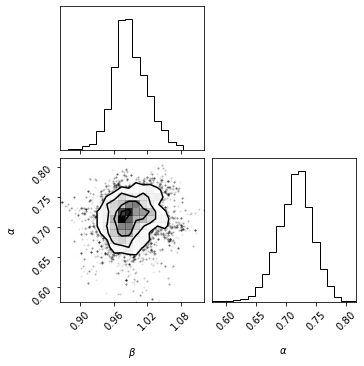

In [17]:
import corner
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))
samples = sampler.chain[:, :, :].reshape((-1, dim))
figure = corner.corner(samples[:,:2],labels=[r"$\beta$",r'$\alpha$'])


beta0 = 0.975
alpha0 = 0.672

Mean acceptance fraction: 0.32550000000000007


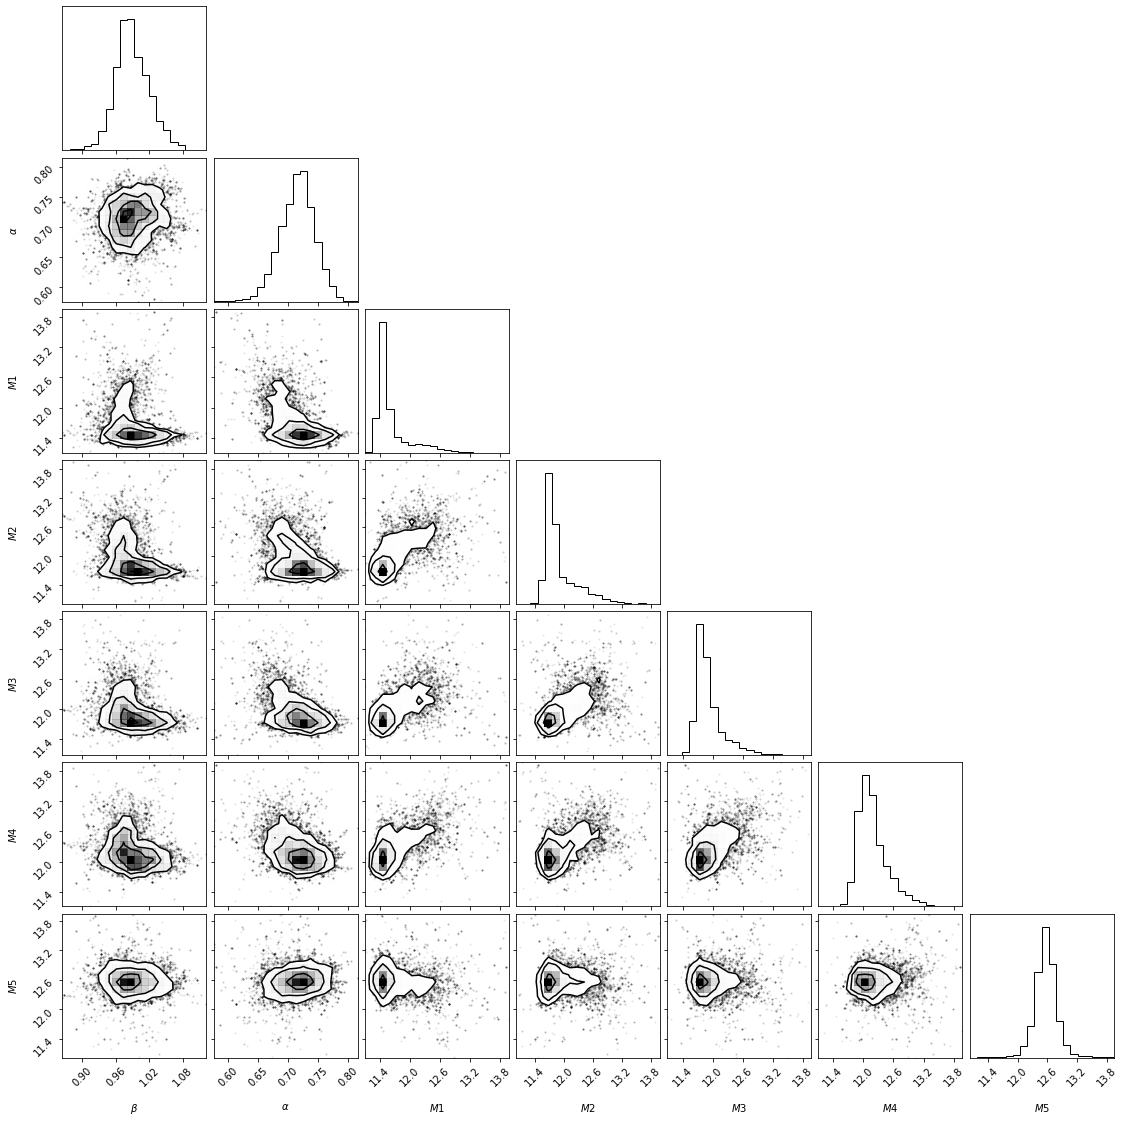

In [18]:
import corner
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))
samples = sampler.chain[:, :, :].reshape((-1, dim))
figure = corner.corner(samples[:,:7],labels=[r"$\beta$",r'$\alpha$',r'$M1$',r'$M2$',r'$M3$',r'$M4$',r'$M5$'])


Mean acceptance fraction: 0.2975


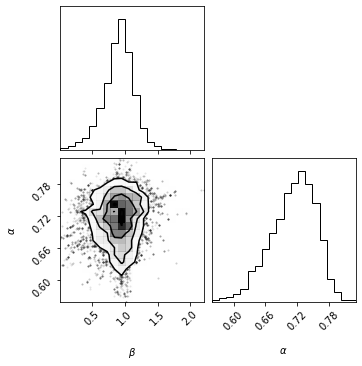

In [20]:
import corner
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))
samples = sampler.chain[:, :, :].reshape((-1, dim))
figure = corner.corner(samples[:,:2],labels=[r"$\beta$",r'$\alpha$'])


Mean acceptance fraction: 0.2975


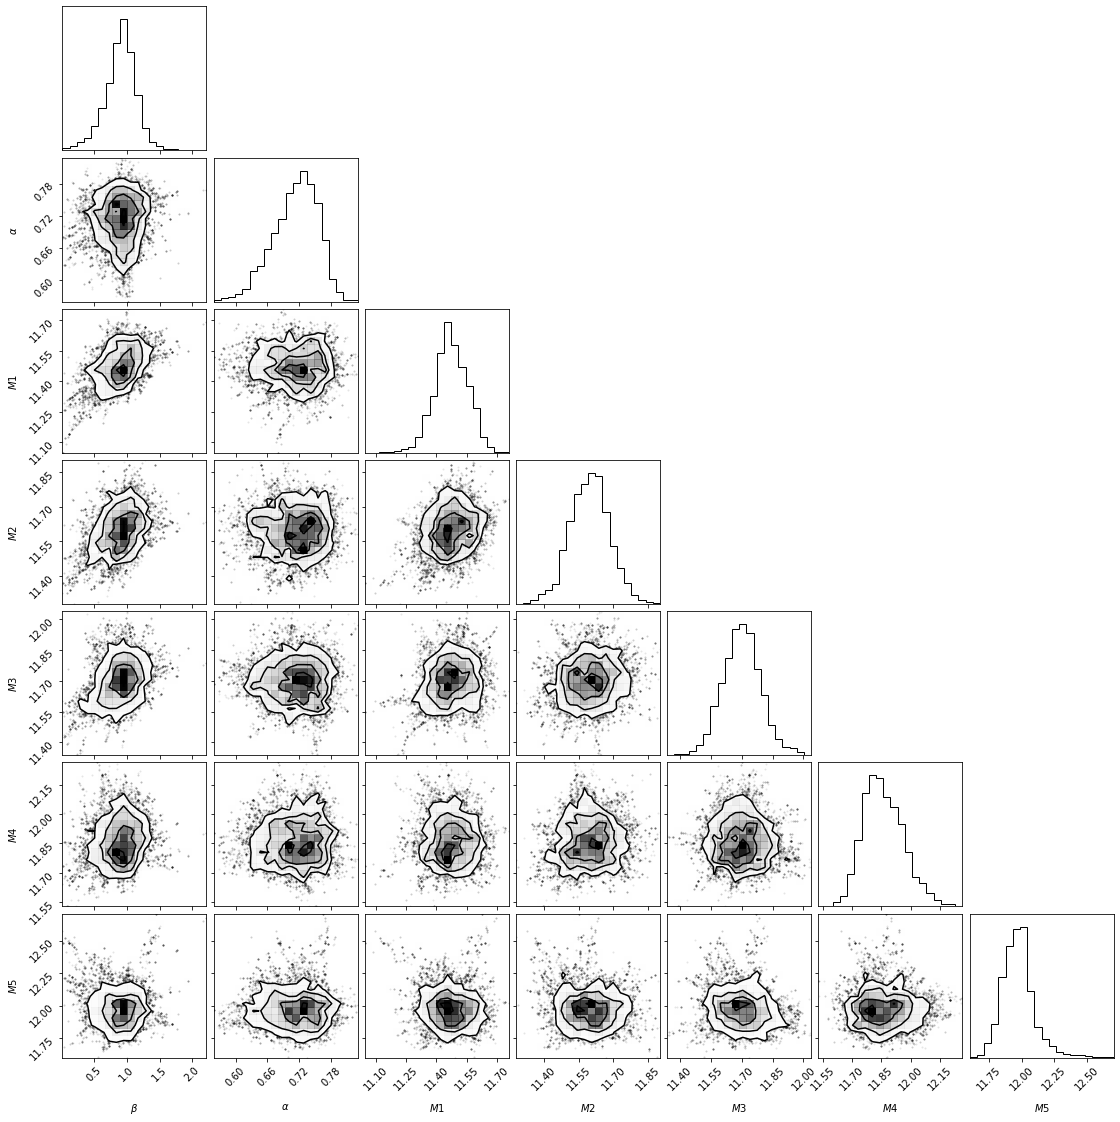

In [22]:
import corner
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))
samples = sampler.chain[:, :, :].reshape((-1, dim))
figure = corner.corner(samples[:,:7],labels=[r"$\beta$",r'$\alpha$',r'$M1$',r'$M2$',r'$M3$',r'$M4$',r'$M5$'])


In [ ]:
beta0 = 0.975
alpha0 = 0.672